#Task 2: Comparing the performance of different pretrained models
Machine Learning Assignment

Duy Tran

19313551

17.05.2022

In [ ]:
!pip install -U d2l

In [10]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from d2l import torch as d2l

In [11]:
# prepare dataset
# ref: https://pytorch.org/vision/stable/models.html
transform = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Resize(224),
       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# validation and training set
full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# download 10000 testing dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

num_classes = 10

# split 50k dataset into train and validation
# ref: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
train_size = int(0.7 * len(full_dataset))
validation_size = len(full_dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(full_dataset, [train_size, validation_size])

Files already downloaded and verified
Files already downloaded and verified


In [12]:
#load test dataset
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=128, 
                                        shuffle=True, num_workers = 4)

In [13]:
# initialise models and adjust final layer to correct number of classes
# ref: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def initialize_model(model_name, num_classes=10, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = torchvision.models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        nn.init.xavier_uniform_(model_ft.fc.weight);

    elif model_name == "alexnet":
        """ Alexnet
        """
        print("alexnet")
        model_ft = torchvision.models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        nn.init.xavier_uniform_(model_ft.classifier[6].weight);

    elif model_name == "vgg":
        """ VGG16
        """
        print("vgg")
        model_ft = torchvision.models.vgg16(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        nn.init.xavier_uniform_(model_ft.classifier[6].weight);
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

In [14]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
# ref: https://d2l.ai/chapter_computer-vision/fine-tuning.html
def train_fine_tuning(model_name, net, learning_rate, batch_size=128, num_epochs=10,
                      param_group=True):
    #load training dataset
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
    #load validation dataset
    val_iter = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss()
    if param_group:
        if model_name=="resnet":
            params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
            trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
        else:
            params_1x = [param for name, param in net.named_parameters()
                if name not in ["classifier.6.weight", "classifier.6.bias"]]
            trainer = torch.optim.SGD([{'params': params_1x},
                                    {'params': net.classifier[6].parameters(),
                                        'lr': learning_rate * 10}],
                                    lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, val_iter, loss, trainer, num_epochs,
                   devices)

### VGG

loss 0.000, train acc 0.983, test acc 0.920
138.3 examples/sec on [device(type='cuda', index=0)]


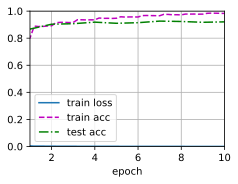

In [15]:
net = initialize_model("vgg")
train_fine_tuning("vgg", net, 5e-3)

In [16]:
#check accuracy of net against test dataset
d2l.evaluate_accuracy_gpu(net, test_iter)

0.913

### Resnet


loss 0.000, train acc 0.998, test acc 0.936
651.6 examples/sec on [device(type='cuda', index=0)]


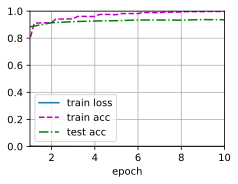

In [17]:
net = initialize_model("resnet")
train_fine_tuning("resnet", net, 5e-3)

In [18]:
#check accuracy of net against test dataset
d2l.evaluate_accuracy_gpu(net, test_iter)

0.9327

### AlexNet


loss 0.001, train acc 0.936, test acc 0.882
1730.4 examples/sec on [device(type='cuda', index=0)]


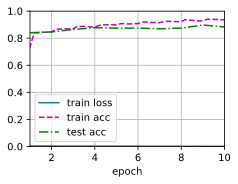

In [19]:
net = initialize_model("alexnet")
train_fine_tuning("alexnet", net, 5e-3)

In [20]:
#check accuracy of net against test dataset
d2l.evaluate_accuracy_gpu(net, test_iter)

0.8865